In [1]:
# from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skfuzzy as fuzz
from scipy.sparse.linalg import svds

In [130]:
#
# Collect data
#
vmin = 1
nmin = 5
name = "vmin"+str(vmin)+"_nmin"+str(nmin)
run = "secondring"
tggroup = "tg_15"
tglen = 15
nTG = 24*60//tglen

vdistpath = "/home/michael/msc/summer17/traffic/data/"+tggroup+"/veldists/"+run+"/"+name+"/"
statepath = "/home/michael/msc/summer17/traffic/data/"+tggroup+"/states/"+run+"/"+name+"/"

finfo = open(vdistpath+"info",'r')
edges = []
Ndists = 0
nx,ny,nth = 0,0,0
dxcell,dycell = 0.,0.
for l in finfo.readlines():
    spt = l.split(" ")
    if spt[0]=="edges:":
        edges = [float(e) for e in spt[1:-1]]
    if spt[0]=="Ndists":
        Ndists = int(spt[1])
    if spt[0]=="Nx":
        nx = int(spt[1])
    if spt[0]=="Ny":
        ny = int(spt[1])
    if spt[0]=="nSlice":
        nth = int(spt[1])
    if spt[0]=="dxCell":
        dxcell = float(spt[1])
    if spt[0]=="dyCell":
        dycell = float(spt[1])

finfo.close()
ndim = len(edges)-1 # the last edge is not its own bin
widths = [r-l for r,l in zip(edges[1:],edges[:-1])]
data = np.zeros(shape=(Ndists,ndim))
gridmap = {}

ncenters = 3 # Doesn't seem to manage >3 very well. Running with
# 4 centers, I found 2 of them overlapped to 1e-5 difference (rdim =10)

reduced_dim = 10
distdata = np.zeros(shape=(nx,ny,nth,7,nTG,ndim))
statedata = np.zeros(shape=(nx,ny,nth,7,nTG,ncenters))

i = 0
for d in range(7):
    for tg in range(nTG):
        fin = open(vdistpath+"/d"+str(d)+"tg"+str(tg),'r')
        for l in fin.readlines():
            spt = l.split(" ")
            x,y,th = int(spt[0]),int(spt[1]),int(spt[2])
            dist = np.asarray([int(dat) for dat in spt[4:-1]])
            data[i] = dist
            distdata[x][y][th][d][tg] = dist
            gridmap.update({i:[x,y,d,tg,th]})
            i+=1

print "Done"

Done


In [133]:
#
# Run fuzzy clustering method
#

# Hopefully two centers representing jam and good flow
# centers = [np.asarray([21, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
#            np.asarray([9, 6, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0])]

fpcs = []

U,S,V = svds(data,k=reduced_dim)
data_svd = U.dot(np.diag(S))  # output of TruncatedSVD
raw_approx = data_svd.dot(V)

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data.T, ncenters, 2, error=0.000001, maxiter=200, init=None)

# Store fpc values for later
fpcs.append(fpc)
    
states = u.T.copy()
for i in range(Ndists):
    x,y,d,tg,th = gridmap[i]
    statedata[x][y][th][d][tg] = states[i]

print ncenters, reduced_dim, p, fpc

3 10 169 0.4078893193


In [114]:
print U.shape, S.shape, V.shape, data.shape, u.shape, cntr.shape

(238409, 10) (10,) (10, 15) (238409, 15) (3, 238409) (3, 10)


In [115]:
# Represents the centers in the original 15 bin dist
cntr2raw = cntr.dot(V)

In [145]:
len(max_args)

238409

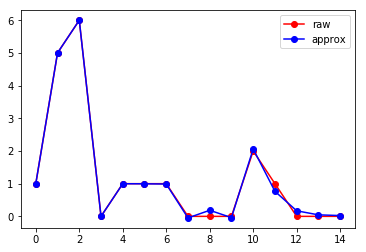

In [150]:
s = max_args[10000]
plt.plot(data[s],"o-r",raw_approx[s],"o-b")
plt.legend(["raw","approx"])

In [135]:
dist_sums = np.sum(data,axis=1)
max_args = np.flipud(np.argsort(dist_sums))
print max_args[0:10]
print dist_sums[max_args[0:10]]

[200000 205291 207467 198013 204763 200637 206245 137309 160721 203116]
[ 81.  78.  75.  75.  73.  72.  71.  68.  67.  65.]


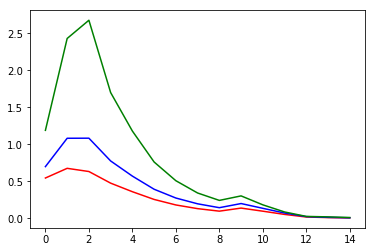

In [134]:
plt.plot(cntr[0],'b')
plt.plot(cntr[1],'r')
plt.plot(cntr[2],'g')
# plt.plot(cntr[3],'k')

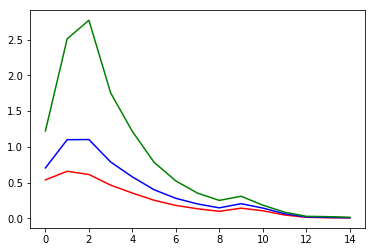

In [116]:
plt.plot(cntr2raw[0],'b')
plt.plot(cntr2raw[1],'r')
plt.plot(cntr2raw[2],'g')
# plt.plot(cntr[3],'k')

In [32]:
statepath

'/home/michael/msc/summer17/traffic/data/tg_15/states/secondring/vmin1_nmin0/'

In [34]:
finfo.close()

In [35]:
# Write states to disk
#
# Now the states are not the distributions
# but their c values
states = u.T.copy()

finfo = open(statepath+"/info",'w')
finfo.write("nx %d\nny %d\nntg %d\nnslice %d\nnstate %d\ntglen %d\n"%(nx,ny,nTG,nth,ncenters,tglen))

# Erase files
for d in range(7):
    for tg in range(nTG):
        fout = open(statepath+"/d"+str(d)+"tg"+str(tg),'w')
        
        for x in range(nx):
            for y in range(ny):
                for th in range(nth):
                    sstr = ""
                    for s in statedata[x][y][th][d][tg]:
                        sstr += str(s)+" "
                    fout.write("%d %d %d "%(x,y,th)+sstr+"\n")
        fout.close()    
print "Done"

Done


In [ ]:
plt.figure(figsize=(8,5))
bins = [e+0.5*w for e,w in zip(edges[:-1],widths)]
plt.bar(bins,cntr[0],widths,color='g',alpha=0.4)
plt.bar(bins,cntr[1],widths,color='b',alpha=0.4)

In [12]:
# Let's see how it groups data based on times we can assume are jam times
jamset = []
flowset = []
jamtimes = [14,15,16,17,18,19,32,33,34,35,36,37]
for d in range(7):
    for tg in range(nTG):
        fin = open(vdistpath+"/d"+str(d)+"tg"+str(tg),'r')
        velset = []
        for l in fin.readlines():
            spt = l.split(" ")
            dist = np.asarray([float(dat) for dat in spt[4:-1]])
            if (tg in jamtimes) and (d in [0,1,2,3,4]):
                jamset.append(dist)
            else:
                flowset.append(dist)
        fin.close()        

In [28]:
u.shape

(2, 709632)

In [13]:
len(jamset)

63360

In [14]:
ndjamset = np.asarray(jamset).T
ndflowset = np.asarray(flowset).T

U,S,V = svds(data,k=reduced_dim)
data_svd = U.dot(np.diag(S))  # output of TruncatedSVD

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_svd.T, ncenters, 2, error=0.000001, maxiter=1000, init=None)




U_,S_,V_ = svds(ndjamset.T,k=reduced_dim)
ndjamset_svd = U_.dot(np.diag(S))
jamset_u = np.empty(shape=(len(jamset),ncenters))

u_, u0_, d_, jm_, p_, fpc_ = fuzz.cmeans_predict(
    ndjamset_svd.T, cntr, 2, error=0.00005, maxiter=1000)

for i in range(len(jamset_u)):
    jamset_u[i] = u_.T[i]
    

# cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization


NameError: name 'jamset' is not defined

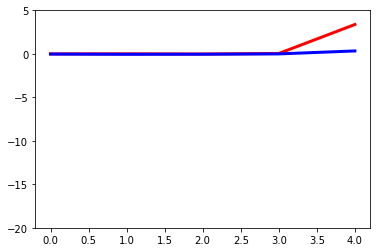

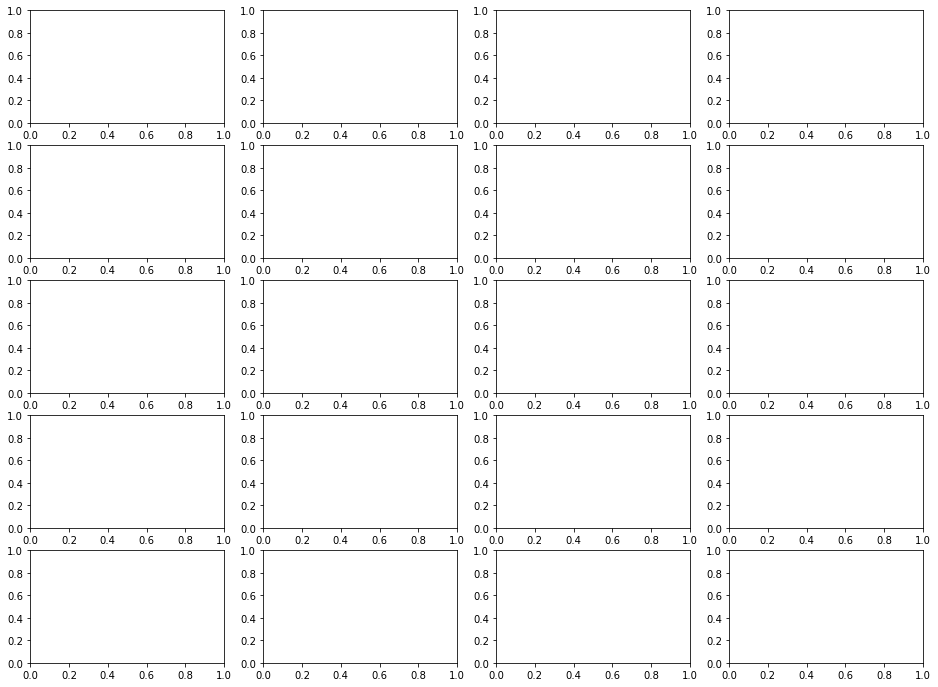

In [27]:
# Hand pick some distributions
plt.plot(cntr[0],color=(1,0,0),linewidth=3.0)
plt.plot(cntr[1],color=(0,0,1),linewidth=3.0)
ymin,ymax = -20,5
plt.ylim(ymin,ymax)

f,ax = plt.subplots(5,4,figsize=(16,12))
start, end = 20,30
j = jamset[start:end]
j_svd = ndjamset_svd[start:end]
j_u = jamset_u[start:end]
colors = [(u[0],0,u[1]) for u in j_u]



ax[0,0].bar(bins,j[0],widths,color=colors[0])
ax[1,0].bar(bins,j[1],widths,color=colors[1])
ax[2,0].bar(bins,j[2],widths,color=colors[2])
ax[3,0].bar(bins,j[3],widths,color=colors[3])
ax[4,0].bar(bins,j[4],widths,color=colors[4])
ax[0,1].bar(bins,j[5],widths,color=colors[5])
ax[1,1].bar(bins,j[6],widths,color=colors[6])
ax[2,1].bar(bins,j[7],widths,color=colors[7])
ax[3,1].bar(bins,j[8],widths,color=colors[8])
ax[4,1].bar(bins,j[9],widths,color=colors[9])

ax[0,2].plot(j_svd[0],color=colors[0])
ax[1,2].plot(j_svd[1],color=colors[1])
ax[2,2].plot(j_svd[2],color=colors[2])
ax[3,2].plot(j_svd[3],color=colors[3])
ax[4,2].plot(j_svd[4],color=colors[4])
ax[0,3].plot(j_svd[5],color=colors[5])
ax[1,3].plot(j_svd[6],color=colors[6])
ax[2,3].plot(j_svd[7],color=colors[7])
ax[3,3].plot(j_svd[8],color=colors[8])
ax[4,3].plot(j_svd[9],color=colors[9])

for m in range(5):
    for mm in [2,3]:
        ax[m,mm].set_ylim(ymin,ymax)
    for mm in [0,1]:
        ax[m,mm].set_ylim(0,12)
       
    

In [ ]:
plt.figure(figsize=(10,6))
plt.plot((d[0][0:50]+d[1][0:50])/25.,'b')
plt.plot(u[0][0:50],'r')

In [ ]:
plt.plot(u[0][0:50])
# plt.plot(d[0][0:40],'r')

In [20]:
u.T.shape

(354816, 2)

In [23]:
statepath

'/home/michael/msc/summer17/traffic/data/states/secondring/vmin1_nmin5/'